<a href="https://colab.research.google.com/github/Tanveer-heir/PredictIQ/blob/main/Predict_IQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import shap

import warnings
warnings.filterwarnings("ignore")


In [ ]:
sales = pd.read_csv("sales_train_validation.csv")
calendar = pd.read_csv("calendar.csv")
prices = pd.read_csv("sell_prices.csv")

print("Sales:", sales.shape)
print("Calendar:", calendar.shape)
print("Prices:", prices.shape)


Sales: (30490, 1919)
Calendar: (1969, 14)
Prices: (6841121, 4)


In [ ]:
# Identify sales columns explicitly
sales_cols = [c for c in sales.columns if c.startswith("d_")]

# Compute demand statistics per ID
demand_stats = sales[["id", "cat_id"] + sales_cols].copy()
demand_stats["mean_demand"] = demand_stats[sales_cols].mean(axis=1)
demand_stats["std_demand"]  = demand_stats[sales_cols].std(axis=1)

# Bucket by demand level
demand_stats["demand_level"] = pd.qcut(
    demand_stats["mean_demand"],
    q=3,
    labels=["low", "medium", "high"]
)

# Deterministic stratified selection
TOTAL_IDS = 3000
IDS_PER_CAT = TOTAL_IDS // demand_stats["cat_id"].nunique()

selected_ids = []

for cat in demand_stats["cat_id"].unique():
    cat_df = demand_stats[demand_stats["cat_id"] == cat]
    for level in ["low", "medium", "high"]:
        subset = cat_df[cat_df["demand_level"] == level]
        subset = subset.sort_values("std_demand", ascending=False)
        selected_ids.extend(subset["id"].head(IDS_PER_CAT // 3).tolist())

selected_ids = list(dict.fromkeys(selected_ids))[:TOTAL_IDS]

print("Selected IDs:", len(selected_ids))

# Filter sales
sales = sales[sales["id"].isin(selected_ids)]


Selected IDs: 2997


In [ ]:
df = sales.melt(
    id_vars=["id", "item_id", "store_id", "state_id", "cat_id"],
    value_vars=sales_cols,
    var_name="day",
    value_name="target"
)

# Ensure target is numeric
df["target"] = pd.to_numeric(df["target"], errors="raise").astype(np.float32)

# Merge calendar
df = df.merge(calendar, left_on="day", right_on="d", how="left")
df["date"] = pd.to_datetime(df["date"])

df = df.sort_values(["id", "date"]).reset_index(drop=True)

df.head()


,id,item_id,store_id,state_id,cat_id,day,target,date,wm_yr_wk,weekday,...,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,FOODS_1_004_CA_3_validation,FOODS_1_004,CA_3,CA,FOODS,d_1,0.0,2011-01-29,11101,Saturday,...,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,FOODS_1_004_CA_3_validation,FOODS_1_004,CA_3,CA,FOODS,d_2,0.0,2011-01-30,11101,Sunday,...,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,FOODS_1_004_CA_3_validation,FOODS_1_004,CA_3,CA,FOODS,d_3,0.0,2011-01-31,11101,Monday,...,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,FOODS_1_004_CA_3_validation,FOODS_1_004,CA_3,CA,FOODS,d_4,0.0,2011-02-01,11101,Tuesday,...,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,FOODS_1_004_CA_3_validation,FOODS_1_004,CA_3,CA,FOODS,d_5,0.0,2011-02-02,11101,Wednesday,...,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [ ]:
df = df.merge(
    prices,
    on=["store_id", "item_id", "wm_yr_wk"],
    how="left"
)

df["sell_price"] = df["sell_price"].ffill()


In [ ]:
df["dayofweek"] = df["date"].dt.dayofweek
df["week"] = df["date"].dt.isocalendar().week.astype("Int16")
df["month"] = df["date"].dt.month

# Cyclical encoding
df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)


In [ ]:
LAGS = [1, 7, 14, 28]
WINDOWS = [7, 14, 28]

for lag in LAGS:
    df[f"lag_{lag}"] = df.groupby("id")["target"].shift(lag)

for win in WINDOWS:
    df[f"rmean_{win}"] = (
        df.groupby("id")["target"]
          .shift(1)
          .rolling(win)
          .mean()
    )


In [ ]:
df = df.dropna().reset_index(drop=True)
print("Data shape after features:", df.shape)


Data shape after features: (11987, 33)


In [ ]:
lag_cols = [c for c in df.columns if c.startswith("lag_") or c.startswith("rmean_")]
df[lag_cols] = df[lag_cols].astype(np.float32)


In [ ]:
exclude_cols = [
    "id", "item_id", "store_id", "state_id", "cat_id",
    "day", "d", "date", "target"
]

cat_cols = [
    c for c in df.select_dtypes(include=["object"]).columns
    if c not in exclude_cols
]

print("Categorical features encoded:", cat_cols)

if len(cat_cols) > 0:
    df[cat_cols] = df[cat_cols].fillna("None")
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)


Categorical features encoded: ['weekday', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']


In [ ]:
HORIZON = 28
max_date = df["date"].max()

train = df[df["date"] <= max_date - pd.Timedelta(days=HORIZON)]
test  = df[df["date"] >  max_date - pd.Timedelta(days=HORIZON)]

TARGET = "target"
FEATURES = [c for c in df.columns if c not in exclude_cols]

X_train, y_train = train[FEATURES], train[TARGET]
X_test, y_test   = test[FEATURES], test[TARGET]

print("Train:", X_train.shape)
print("Test :", X_test.shape)


Train: (8990, 27)
Test : (2997, 27)


In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / np.maximum(denom, 1e-8)
    return 100 * np.mean(diff)


In [ ]:
xgb = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)


In [ ]:
xgb_pred = xgb.predict(X_test)

print("XGBoost RMSE :", rmse(y_test.values, xgb_pred))
print("XGBoost MAE  :", mae(y_test.values, xgb_pred))
print("XGBoost SMAPE:", smape(y_test.values, xgb_pred))


XGBoost RMSE : 5.4941053
XGBoost MAE  : 2.1617906
XGBoost SMAPE: 142.33498


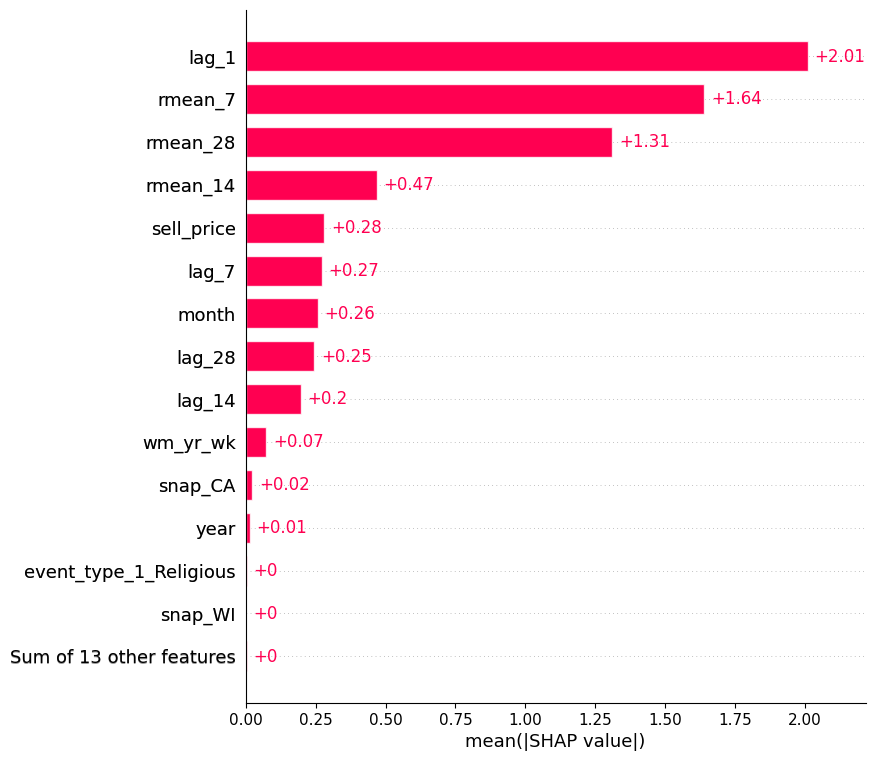

In [ ]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

shap.plots.bar(shap_values, max_display=15)


In [ ]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1327
[LightGBM] [Info] Number of data points in the train set: 8990, number of used features: 20
[LightGBM] [Info] Start training from score 3.578754


In [ ]:
print("LightGBM RMSE :", rmse(y_test.values, lgbm_pred))
print("LightGBM MAE  :", mae(y_test.values, lgbm_pred))
print("LightGBM SMAPE:", smape(y_test.values, lgbm_pred))


LightGBM RMSE : 5.886259022537854
LightGBM MAE  : 2.2775957429558322
LightGBM SMAPE: 142.3676659438077


In [ ]:
weights = np.linspace(0, 1, 11)

best = {"rmse": np.inf}

for w in weights:
    pred = w * lgbm_pred + (1 - w) * xgb_pred
    r = rmse(y_test.values, pred)

    if r < best["rmse"]:
        best = {"rmse": r, "w_lgbm": w}

best


{'rmse': np.float64(5.494105117640616), 'w_lgbm': np.float64(0.0)}

In [ ]:
ensemble_pred = best["w_lgbm"] * lgbm_pred + (1 - best["w_lgbm"]) * xgb_pred


In [ ]:
print("ENSEMBLE RMSE :", rmse(y_test.values, ensemble_pred))
print("ENSEMBLE MAE  :", mae(y_test.values, ensemble_pred))
print("ENSEMBLE SMAPE:", smape(y_test.values, ensemble_pred))


ENSEMBLE RMSE : 5.494105117640616
ENSEMBLE MAE  : 2.161790764878492
ENSEMBLE SMAPE: 142.3349868239798


In [ ]:
non_zero_mask = y_test.values > 0

print("RMSE (non-zero):", rmse(y_test.values[non_zero_mask],
                               ensemble_pred[non_zero_mask]))
print("MAE  (non-zero):", mae(y_test.values[non_zero_mask],
                               ensemble_pred[non_zero_mask]))


RMSE (non-zero): 8.270952442588953
MAE  (non-zero): 4.25474893957207


In [ ]:
results = pd.DataFrame({
    "Model": ["XGBoost", "LightGBM", "Ensemble"],
    "RMSE": [
        rmse(y_test.values, xgb_pred),
        rmse(y_test.values, lgbm_pred),
        rmse(y_test.values, ensemble_pred)
    ],
    "MAE": [
        mae(y_test.values, xgb_pred),
        mae(y_test.values, lgbm_pred),
        mae(y_test.values, ensemble_pred)
    ],
    "SMAPE": [
        smape(y_test.values, xgb_pred),
        smape(y_test.values, lgbm_pred),
        smape(y_test.values, ensemble_pred)
    ]
})

results


,Model,RMSE,MAE,SMAPE
0,XGBoost,5.494105,2.161791,142.334976
1,LightGBM,5.886259,2.277596,142.367666
2,Ensemble,5.494105,2.161791,142.334987


In [ ]:
# Binary target: did demand occur?
df["occur"] = (df["target"] > 0).astype(int)


In [ ]:
from lightgbm import LGBMClassifier

# Train/test split already defined earlier
X_train, y_train = train[FEATURES], train["target"]
X_test, y_test   = test[FEATURES], test["target"]

y_train_occ = (y_train > 0).astype(int)
y_test_occ  = (y_test > 0).astype(int)

clf = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

clf.fit(X_train, y_train_occ)

p_occ = clf.predict_proba(X_test)[:, 1]


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2840, number of negative: 6150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1327
[LightGBM] [Info] Number of data points in the train set: 8990, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315907 -> initscore=-0.772648
[LightGBM] [Info] Start training from score -0.772648


In [ ]:
# Filter non-zero demand rows
nz_train = train[train["target"] > 0]
nz_test  = test[test["target"] > 0]

X_nz_train = nz_train[FEATURES]
y_nz_train = nz_train["target"]

mag_model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

mag_model.fit(X_nz_train, y_nz_train)

# Predict expected magnitude (fallback = 0)
mag_pred = np.zeros(len(test))
mag_pred[test.index.get_indexer(nz_test.index)] = mag_model.predict(
    nz_test[FEATURES]
)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1255
[LightGBM] [Info] Number of data points in the train set: 2840, number of used features: 20
[LightGBM] [Info] Start training from score 11.328521


In [ ]:
two_stage_pred = p_occ * mag_pred


In [ ]:
print("Two-stage RMSE:", rmse(y_test.values, two_stage_pred))
print("Two-stage MAE :", mae(y_test.values, two_stage_pred))

# Non-zero only
nz = y_test.values > 0
print("Two-stage RMSE (non-zero):", rmse(y_test.values[nz], two_stage_pred[nz]))
print("Two-stage MAE  (non-zero):", mae(y_test.values[nz], two_stage_pred[nz]))


Two-stage RMSE: 5.7079686770457725
Two-stage MAE : 1.8829331571313392
Two-stage RMSE (non-zero): 8.906271420834306
Two-stage MAE  (non-zero): 4.584200383365251


In [ ]:
quantiles = [0.1, 0.5, 0.9]
q_models = {}

for q in quantiles:
    model = LGBMRegressor(
        objective="quantile",
        alpha=q,
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X_nz_train, y_nz_train)
    q_models[q] = model


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1255
[LightGBM] [Info] Number of data points in the train set: 2840, number of used features: 20
[LightGBM] [Info] Start training from score 1.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1255
[LightGBM] [Info] Number of data points in the train set: 2840, number of used features: 20
[LightGBM] [Info] Start training from score 5.000000
[LightGBM] [Warning] Found whi

In [ ]:
q_preds = {}

for q, model in q_models.items():
    preds = np.zeros(len(test))
    preds[test.index.get_indexer(nz_test.index)] = model.predict(
        nz_test[FEATURES]
    )
    q_preds[q] = preds

# Combine with occurrence probability
q10 = p_occ * q_preds[0.1]
q50 = p_occ * q_preds[0.5]
q90 = p_occ * q_preds[0.9]


In [ ]:
# Pick ID with most non-zero days in test
active_ids = (
    test.groupby("id")["target"]
        .apply(lambda x: (x > 0).sum())
        .sort_values(ascending=False)
)

sample_id = active_ids.index[0]
plot_df = test[test["id"] == sample_id]
idx = test.index.get_indexer(plot_df.index)

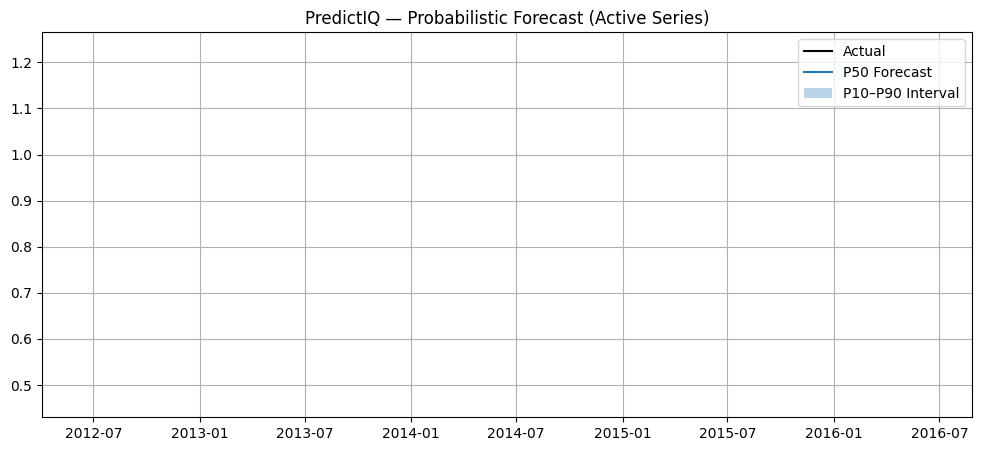

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(plot_df["date"], plot_df["target"], label="Actual", color="black")
plt.plot(plot_df["date"], q50[idx], label="P50 Forecast")
plt.fill_between(
    plot_df["date"],
    q10[idx],
    q90[idx],
    alpha=0.3,
    label="P10–P90 Interval"
)
plt.legend()
plt.title("PredictIQ — Probabilistic Forecast (Active Series)")
plt.grid(True)
plt.show()


In [ ]:
id_activity = (
    test.groupby("id")["target"]
        .agg(
            non_zero_days=lambda x: (x > 0).sum(),
            total_demand="sum",
            std_demand="std",
            count="count"
        )
        .sort_values(
            by=["non_zero_days", "total_demand", "std_demand"],
            ascending=False
        )
)

id_activity.head(10)


,non_zero_days,total_demand,std_demand,count
id,,,,
FOODS_3_090_CA_3_validation,1,168.0,NaN,1
FOODS_3_090_WI_3_validation,1,140.0,NaN,1
FOODS_3_586_TX_2_validation,1,123.0,NaN,1
FOODS_3_090_CA_1_validation,1,114.0,NaN,1
FOODS_3_319_CA_3_validation,1,114.0,NaN,1
FOODS_3_007_WI_2_validation,1,111.0,NaN,1
FOODS_3_541_CA_3_validation,1,109.0,NaN,1
FOODS_3_090_TX_2_validation,1,100.0,NaN,1
FOODS_3_090_TX_3_validation,1,99.0,NaN,1


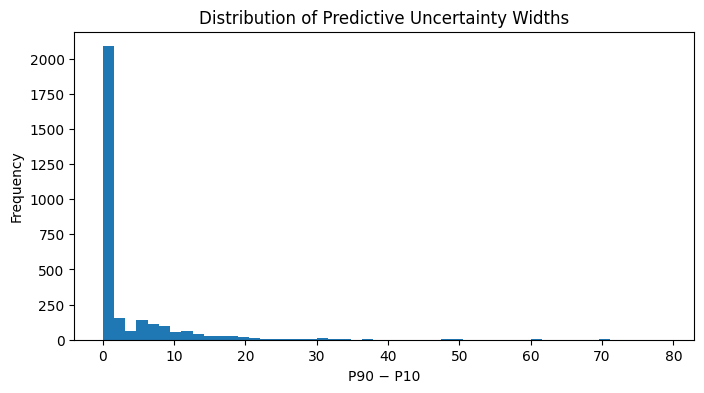

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(q90 - q10, bins=50)
plt.title("Distribution of Predictive Uncertainty Widths")
plt.xlabel("P90 − P10")
plt.ylabel("Frequency")
plt.show()


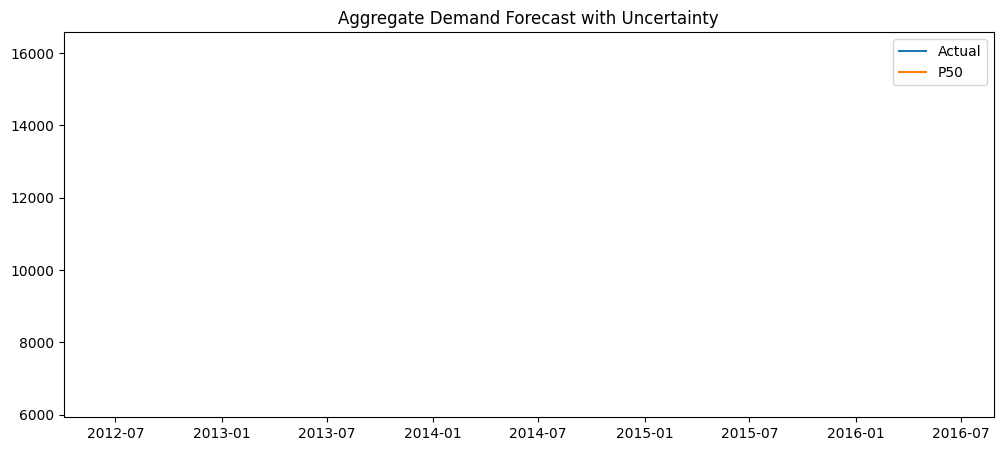

In [ ]:
agg = test.copy()
agg["q50"] = q50
agg["q10"] = q10
agg["q90"] = q90

agg_ts = agg.groupby("date")[["target", "q50", "q10", "q90"]].sum().reset_index()

plt.figure(figsize=(12,5))
plt.plot(agg_ts["date"], agg_ts["target"], label="Actual")
plt.plot(agg_ts["date"], agg_ts["q50"], label="P50")
plt.fill_between(agg_ts["date"], agg_ts["q10"], agg_ts["q90"], alpha=0.3)
plt.legend()
plt.title("Aggregate Demand Forecast with Uncertainty")
plt.show()
